# THCHS30 - 创建 Mel 频谱图

音频经过了以下变换：

1. 采样率与原始音频保持一致 `16000hz`
1. `win_length` 设置为 `100ms`，`hop_length` 设置为 `50ms`
1. Mel 频谱图 [filter-bank](https://librosa.org/doc/latest/generated/librosa.filters.mel.html) 选择 `80`
1. 将 Mel 频谱图转换成 [power spectrogram](https://librosa.org/doc/latest/generated/librosa.power_to_db.html)
1. 将取值范围调整到 `[0, 1]`

文本经过以下变换：

1. 拼音经过 [拼音字典](https://github.com/wu-jingtao/training-data/blob/master/speech_recognition/chinese/拼音字典/README.md) 转换成对应的数字索引

In [ ]:
import os
import re
import json
import glob
import datetime
import librosa
import librosa.display
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

## 挂载 Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 解压数据

数据来自：[THCHS30数据下载.ipynb](https://github.com/wu-jingtao/training-data/blob/master/speech_recognition/chinese/THCHS30/notebooks/THCHS30数据下载.ipynb)

In [ ]:
!tar zxvf /content/drive/Shareddrives/TeamDrive_top_edu/原始数据/THCHS30/data_thchs30.tgz > unzip_log.txt

In [ ]:
!tar zxvf /content/drive/Shareddrives/TeamDrive_top_edu/原始数据/THCHS30/test-noise.tgz > unzip_log.txt

## 加载拼音字典

In [ ]:
!wget https://raw.githubusercontent.com/wu-jingtao/training-data/master/speech_recognition/chinese/拼音字典/pinyin_mapper.json

In [ ]:
!wget https://raw.githubusercontent.com/wu-jingtao/training-data/master/speech_recognition/chinese/拼音字典/pinyin_mapper_without_intonation.json

In [ ]:
with open('pinyin_mapper.json') as f:
  pinyin_mapper = json.load(f)

In [ ]:
with open('pinyin_mapper_without_intonation.json') as f:
  pinyin_mapper_without_intonation = json.load(f)

## 文件列表

In [ ]:
audio_list = glob.glob('/content/data_thchs30/data/*.wav')
noise_audio_list = glob.glob('/content/test-noise/0db/**/*.wav')

## 读取音频对应文本

In [ ]:
audio_words = dict()
audio_pinyins = dict()

for path in audio_list:
  name = os.path.splitext(os.path.split(path)[1])[0]
  with open(path + '.trn') as f:
    words = next(f).strip()
    words = list(filter(lambda x: x != ' ', words))
    pinyins = next(f).strip().split(' ')
    audio_words[name] = words
    audio_pinyins[name] = pinyins

## 构建 [Mel](https://librosa.org/doc/latest/generated/librosa.feature.melspectrogram.html) 频谱图

In [ ]:
def get_melspectrogram(file_list):
  def generator():
    for path in file_list:
      audio, sr = librosa.load(path, sr=None)
      S = librosa.feature.melspectrogram(audio, sr, n_fft=sr//10, hop_length=sr//20, n_mels=80)
      S_dB = librosa.power_to_db(S, ref=np.max)
      S_dB = (S_dB + 80) / 80
      yield S_dB.T
  return generator

In [ ]:
mel = tf.data.Dataset.from_generator(get_melspectrogram(audio_list), output_signature=tf.TensorSpec(shape=(None, 80), dtype=tf.float32))
noise_mel = tf.data.Dataset.from_generator(get_melspectrogram(noise_audio_list), output_signature=tf.TensorSpec(shape=(None, 80), dtype=tf.float32))

查看效果

数据形状 (200, 80)


[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

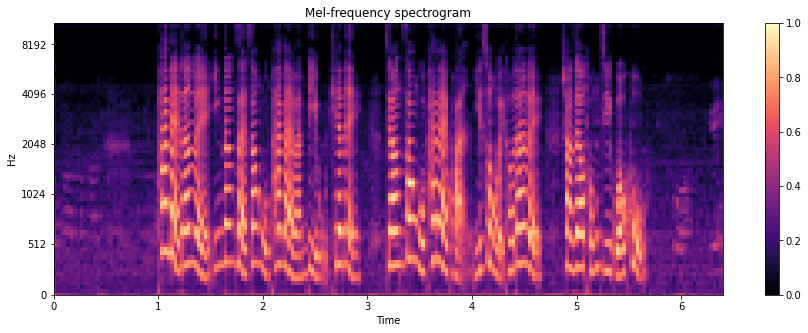

In [ ]:
sample_data = next(mel.as_numpy_iterator())
print(f'数据形状 {sample_data.shape}')

fig, ax = plt.subplots(figsize=(15, 5))
img = librosa.display.specshow(sample_data.T, x_axis='time', y_axis='mel', sr=16000, ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='Mel-frequency spectrogram')

## 构建文本

In [ ]:
def get_words(file_list):
  def generator():
    for path in file_list:
      name = os.path.splitext(os.path.split(path)[1])[0]
      yield audio_words[name]
  return generator

In [ ]:
words = tf.data.Dataset.from_generator(get_words(audio_list), output_signature=tf.TensorSpec(shape=(None,), dtype=tf.string))
noise_words = tf.data.Dataset.from_generator(get_words(noise_audio_list), output_signature=tf.TensorSpec(shape=(None,), dtype=tf.string))

查看效果

In [ ]:
' '.join(map(lambda x: str(x, 'utf-8'), next(words.as_numpy_iterator())))

'拍 卖 单 位 应 当 在 赃 物 拍 卖 完 毕 五 天 内 将 赃 物 拍 卖 款 移 送 委 托 单 位 上 交 同 级 国 库'

## 构建拼音

In [ ]:
def get_pinyins(file_list):
  def generator():
    for path in file_list:
      name = os.path.splitext(os.path.split(path)[1])[0]
      yield audio_pinyins[name]
  return generator

In [ ]:
pinyins = tf.data.Dataset.from_generator(get_pinyins(audio_list), output_signature=tf.TensorSpec(shape=(None,), dtype=tf.string))
noise_pinyins = tf.data.Dataset.from_generator(get_pinyins(noise_audio_list), output_signature=tf.TensorSpec(shape=(None,), dtype=tf.string))

查看效果

In [ ]:
' '.join(map(lambda x: str(x, 'utf-8'), next(pinyins.as_numpy_iterator())))

'pai1 mai4 dan1 wei4 ying1 dang1 zai4 zang1 wu4 pai1 mai4 wan2 bi4 wu3 tian1 nei4 jiang1 zang1 wu4 pai1 mai4 kuan3 yi2 song4 wei3 tuo1 dan1 wei4 shang4 jiao1 tong2 ji2 guo2 ku4'

## 构建有声调拼音索引

In [ ]:
def get_pinyin_index(file_list):
  def generator():
    regex = re.compile('^([a-z]+)(\d?)$')
    for path in file_list:
      name = os.path.splitext(os.path.split(path)[1])[0]
      pinyins = audio_pinyins[name]
      result = np.empty(shape=len(pinyins), dtype=np.uint16)
      for i, pinyin in enumerate(pinyins):
        yin, diao = regex.match(pinyin).groups()
        if diao != '' and diao in '1234':
          result[i] = pinyin_mapper[pinyin]
        else:
          # 将第5声轻音归为1声
          result[i] = pinyin_mapper[yin + '1']
      yield result
  return generator

In [ ]:
pinyin_index = tf.data.Dataset.from_generator(get_pinyin_index(audio_list), output_signature=tf.TensorSpec(shape=(None,), dtype=tf.uint16))
noise_pinyin_index = tf.data.Dataset.from_generator(get_pinyin_index(noise_audio_list), output_signature=tf.TensorSpec(shape=(None,), dtype=tf.uint16))

查看效果

In [ ]:
sample_data = next(pinyin_index.as_numpy_iterator())
sample_data = list(map(lambda x: str(x), sample_data))
print(' '.join(sample_data))
print(' '.join(map(lambda x: pinyin_mapper[x], sample_data)))

952 767 232 1363 1464 236 1503 1508 1379 952 767 1353 55 1378 1300 863 536 1508 1379 952 767 634 1457 1243 1362 1340 232 1363 1175 540 1317 525 445 623
pai1 mai4 dan1 wei4 ying1 dang1 zai4 zang1 wu4 pai1 mai4 wan2 bi4 wu3 tian1 nei4 jiang1 zang1 wu4 pai1 mai4 kuan3 yi2 song4 wei3 tuo1 dan1 wei4 shang4 jiao1 tong2 ji2 guo2 ku4


## 构建无声调拼音索引

In [ ]:
def get_pinyin_index_without_intonation(file_list):
  def generator():
    regex = re.compile('^([a-z]+)\d?$')
    for path in file_list:
      name = os.path.splitext(os.path.split(path)[1])[0]
      pinyins = audio_pinyins[name]
      result = np.empty(shape=len(pinyins), dtype=np.uint16)
      for i, pinyin in enumerate(pinyins):
        yin = regex.match(pinyin).group(1)
        result[i] = pinyin_mapper_without_intonation[yin]
      yield result
  return generator

In [ ]:
pinyin_index_without_intonation = tf.data.Dataset.from_generator(get_pinyin_index_without_intonation(audio_list), output_signature=tf.TensorSpec(shape=(None,), dtype=tf.uint16))
noise_pinyin_index_without_intonation = tf.data.Dataset.from_generator(get_pinyin_index_without_intonation(noise_audio_list), output_signature=tf.TensorSpec(shape=(None,), dtype=tf.uint16))

查看效果

In [ ]:
sample_data = next(pinyin_index_without_intonation.as_numpy_iterator())
sample_data = list(map(lambda x: str(x), sample_data))
print(' '.join(sample_data))
print(' '.join(map(lambda x: pinyin_mapper_without_intonation[x], sample_data)))

238 191 58 340 366 59 375 377 344 238 191 338 13 344 325 215 134 377 344 238 191 158 364 310 340 335 58 340 293 135 329 131 111 155
pai mai dan wei ying dang zai zang wu pai mai wan bi wu tian nei jiang zang wu pai mai kuan yi song wei tuo dan wei shang jiao tong ji guo ku


## 创建缓存数据

无噪音数据

In [ ]:
!mkdir THCHS30_mel

In [ ]:
mel_cache = mel.cache('THCHS30_mel/audios')
words_cache = words.cache('THCHS30_mel/words')
pinyins_cache = pinyins.cache('THCHS30_mel/pinyins')
pinyin_index_cache = pinyin_index.cache('THCHS30_mel/pinyin_index')
pinyin_index_without_intonation_cache = pinyin_index_without_intonation.cache('THCHS30_mel/pinyin_index_without_intonation')

In [ ]:
with tqdm(total=len(audio_list), desc='mel_cache') as pbar:
  for i in mel_cache: pbar.update()

with tqdm(total=len(audio_list), desc='words_cache') as pbar:
  for i in words_cache: pbar.update()

with tqdm(total=len(audio_list), desc='pinyins_cache') as pbar:
  for i in pinyins_cache: pbar.update()

with tqdm(total=len(audio_list), desc='pinyin_index_cache') as pbar:
  for i in pinyin_index_cache: pbar.update()

with tqdm(total=len(audio_list), desc='pinyin_index_without_intonation_cache') as pbar:
  for i in pinyin_index_without_intonation_cache: pbar.update()

pinyin_index_without_intonation_cache: 100%|██████████| 13388/13388 [00:05<00:00, 2555.60it/s]


有噪音数据

In [ ]:
!mkdir THCHS30_mel_noise

In [ ]:
noise_mel_cache = noise_mel.cache('THCHS30_mel_noise/audios')
noise_words_cache = noise_words.cache('THCHS30_mel_noise/words')
noise_pinyins_cache = noise_pinyins.cache('THCHS30_mel_noise/pinyins')
noise_pinyin_index_cache = noise_pinyin_index.cache('THCHS30_mel_noise/pinyin_index')
noise_pinyin_index_without_intonation_cache = noise_pinyin_index_without_intonation.cache('THCHS30_mel_noise/pinyin_index_without_intonation')

In [ ]:
with tqdm(total=len(noise_audio_list), desc='noise_mel_cache') as pbar:
  for i in noise_mel_cache: pbar.update()

with tqdm(total=len(noise_audio_list), desc='noise_words_cache') as pbar:
  for i in noise_words_cache: pbar.update()

with tqdm(total=len(noise_audio_list), desc='noise_pinyins_cache') as pbar:
  for i in noise_pinyins_cache: pbar.update()

with tqdm(total=len(noise_audio_list), desc='noise_pinyin_index_cache') as pbar:
  for i in noise_pinyin_index_cache: pbar.update()

with tqdm(total=len(noise_audio_list), desc='noise_pinyin_index_without_intonation_cache') as pbar:
  for i in noise_pinyin_index_without_intonation_cache: pbar.update()

noise_pinyin_index_without_intonation_cache: 100%|██████████| 7485/7485 [00:02<00:00, 2534.39it/s]


## 创建说明文件

In [ ]:
readme = '''数据来源：http://www.openslr.org/18/
项目地址：https://github.com/wu-jingtao/training-data/blob/master/speech_recognition/chinese/README.md
创建时间：{}

数据类型：
audios：音频对应的 mel 频谱图
  {}

words：音频对应的文字
  {}

pinyins：音频对应的拼音
  {}

pinyin_index：音频对应的带声调拼音索引
  {}

pinyin_index_without_intonation：音频对应的不带声调拼音索引
  {}

示例代码：
>>> data = tf.data.Dataset.from_generator(lambda: None, output_signature=tf.TensorSpec(shape=(None, 80), dtype=tf.float32))
>>> data = data.cache('文件夹路径/audio')
'''

readme = readme.format(
      datetime.datetime.today(),
      mel_cache.element_spec,
      words_cache.element_spec,
      pinyins_cache.element_spec,
      pinyin_index_cache.element_spec,
      pinyin_index_without_intonation_cache.element_spec
    )

with open('THCHS30_mel/README.txt', 'w') as f:
  f.write(readme)

with open('THCHS30_mel_noise/README.txt', 'w') as f:
  f.write(readme)

## 压缩文件

In [ ]:
!7z a THCHS30_mel.7z THCHS30_mel > zip_log.txt

In [ ]:
!7z a THCHS30_mel_noise.7z THCHS30_mel_noise > zip_noise_log.txt

## 保存到 Google Drive

In [ ]:
!cp THCHS30_mel.7z /content/drive/Shareddrives/TeamDrive_top_edu/生成数据/THCHS30_mel.7z

In [ ]:
!cp THCHS30_mel_noise.7z /content/drive/Shareddrives/TeamDrive_top_edu/生成数据/THCHS30_mel_noise.7z

In [ ]:
!cp -r THCHS30_mel /content/drive/Shareddrives/TeamDrive_top_edu/生成数据/

In [ ]:
!cp -r THCHS30_mel_noise /content/drive/Shareddrives/TeamDrive_top_edu/生成数据/